# 语音业务——语音通话稳定性

In [1]:
from sklearnex import patch_sklearn, config_context
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor,StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier,StackingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import missingno as msno
from time import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']

##  预处理数据导入

In [3]:
train = pd.read_excel("./output/语音训练集.xlsx")

In [4]:
train_data = pd.DataFrame.copy(train, deep=True)
train_data

,用户id,语音通话整体满意度,网络覆盖与信号强度,语音通话清晰度,语音通话稳定性,是否遇到过网络问题,居民小区,办公室,高校,商业街,...,前3月ARPU,前3月MOU,外省流量占比,GPRS总流量（KB）,GPRS-国内漫游-流量（KB）,是否5G网络客户,是否实名登记用户,客户星级标识,当月欠费金额,前第3个月欠费金额
0,1,10,6,6,6,0,0,1,0,0,...,0.0,480,1.0,8450801,8450801,1.0,0.0,7.0,0.0,0.00
1,2,2,1,1,1,0,1,1,0,1,...,0.0,480,1.0,17425910,17425910,1.0,1.0,7.0,0.0,0.00
2,3,10,7,7,7,0,0,0,0,0,...,0.0,413,1.0,6215849,6215849,0.0,0.0,4.0,0.0,3.76
3,4,6,7,7,6,0,1,1,0,0,...,0.0,301,1.0,5370710,5370710,1.0,0.0,4.0,0.0,0.00
4,5,5,5,4,3,0,0,1,0,0,...,0.0,1193,1.0,3857521,3857521,0.0,0.0,7.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5428,5429,10,10,10,8,0,0,1,0,0,...,0.0,320,0.0,16654303,0,0.0,0.0,3.0,0.0,0.00
5429,5430,10,10,10,10,0,1,1,0,0,...,0.0,147,0.0,627901,0,1.0,0.0,4.0,0.0,0.00
5430,5431,6,5,7,4,0,0,0,0,1,...,0.0,150,0.0,6816663,0,0.0,0.0,7.0,0.0,0.00
5431,5432,9,9,10,9,0,0,0,0,0,...,0.0,82,0.0,1841891,0,0.0,0.0,4.0,0.0,0.00


In [5]:
train_data=train_data.drop(['用户id', '语音通话整体满意度', '网络覆盖与信号强度', '语音通话清晰度'],axis=1)
train_data

,语音通话稳定性,是否遇到过网络问题,居民小区,办公室,高校,商业街,地铁,农村,高铁,其他，请注明,...,前3月ARPU,前3月MOU,外省流量占比,GPRS总流量（KB）,GPRS-国内漫游-流量（KB）,是否5G网络客户,是否实名登记用户,客户星级标识,当月欠费金额,前第3个月欠费金额
0,6,0,0,1,0,0,0,0,0,0,...,0.0,480,1.0,8450801,8450801,1.0,0.0,7.0,0.0,0.00
1,1,0,1,1,0,1,0,0,0,0,...,0.0,480,1.0,17425910,17425910,1.0,1.0,7.0,0.0,0.00
2,7,0,0,0,0,0,0,1,0,0,...,0.0,413,1.0,6215849,6215849,0.0,0.0,4.0,0.0,3.76
3,6,0,1,1,0,0,0,0,0,0,...,0.0,301,1.0,5370710,5370710,1.0,0.0,4.0,0.0,0.00
4,3,0,0,1,0,0,1,0,1,0,...,0.0,1193,1.0,3857521,3857521,0.0,0.0,7.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5428,8,0,0,1,0,0,0,0,0,0,...,0.0,320,0.0,16654303,0,0.0,0.0,3.0,0.0,0.00
5429,10,0,1,1,0,0,0,0,1,0,...,0.0,147,0.0,627901,0,1.0,0.0,4.0,0.0,0.00
5430,4,0,0,0,0,1,0,0,0,1,...,0.0,150,0.0,6816663,0,0.0,0.0,7.0,0.0,0.00
5431,9,0,0,0,0,0,1,1,0,0,...,0.0,82,0.0,1841891,0,0.0,0.0,4.0,0.0,0.00


## 相关性分析

In [6]:
cor = pd.DataFrame(train_data.corr().abs()["语音通话稳定性"].sort_values(ascending = False))
cor.columns = ["语音通话稳定性"]
cor[0:20]

,语音通话稳定性
语音通话稳定性,1.000000
是否遇到过网络问题,0.466327
居民小区,0.423242
通话过程中突然中断,0.413059
手机没有信号,0.393437
有信号无法拨通,0.376180
通话过程中一方听不见,0.375126
通话中有杂音、听不清、断断续续,0.369030
办公室,0.362459
商业街,0.243412


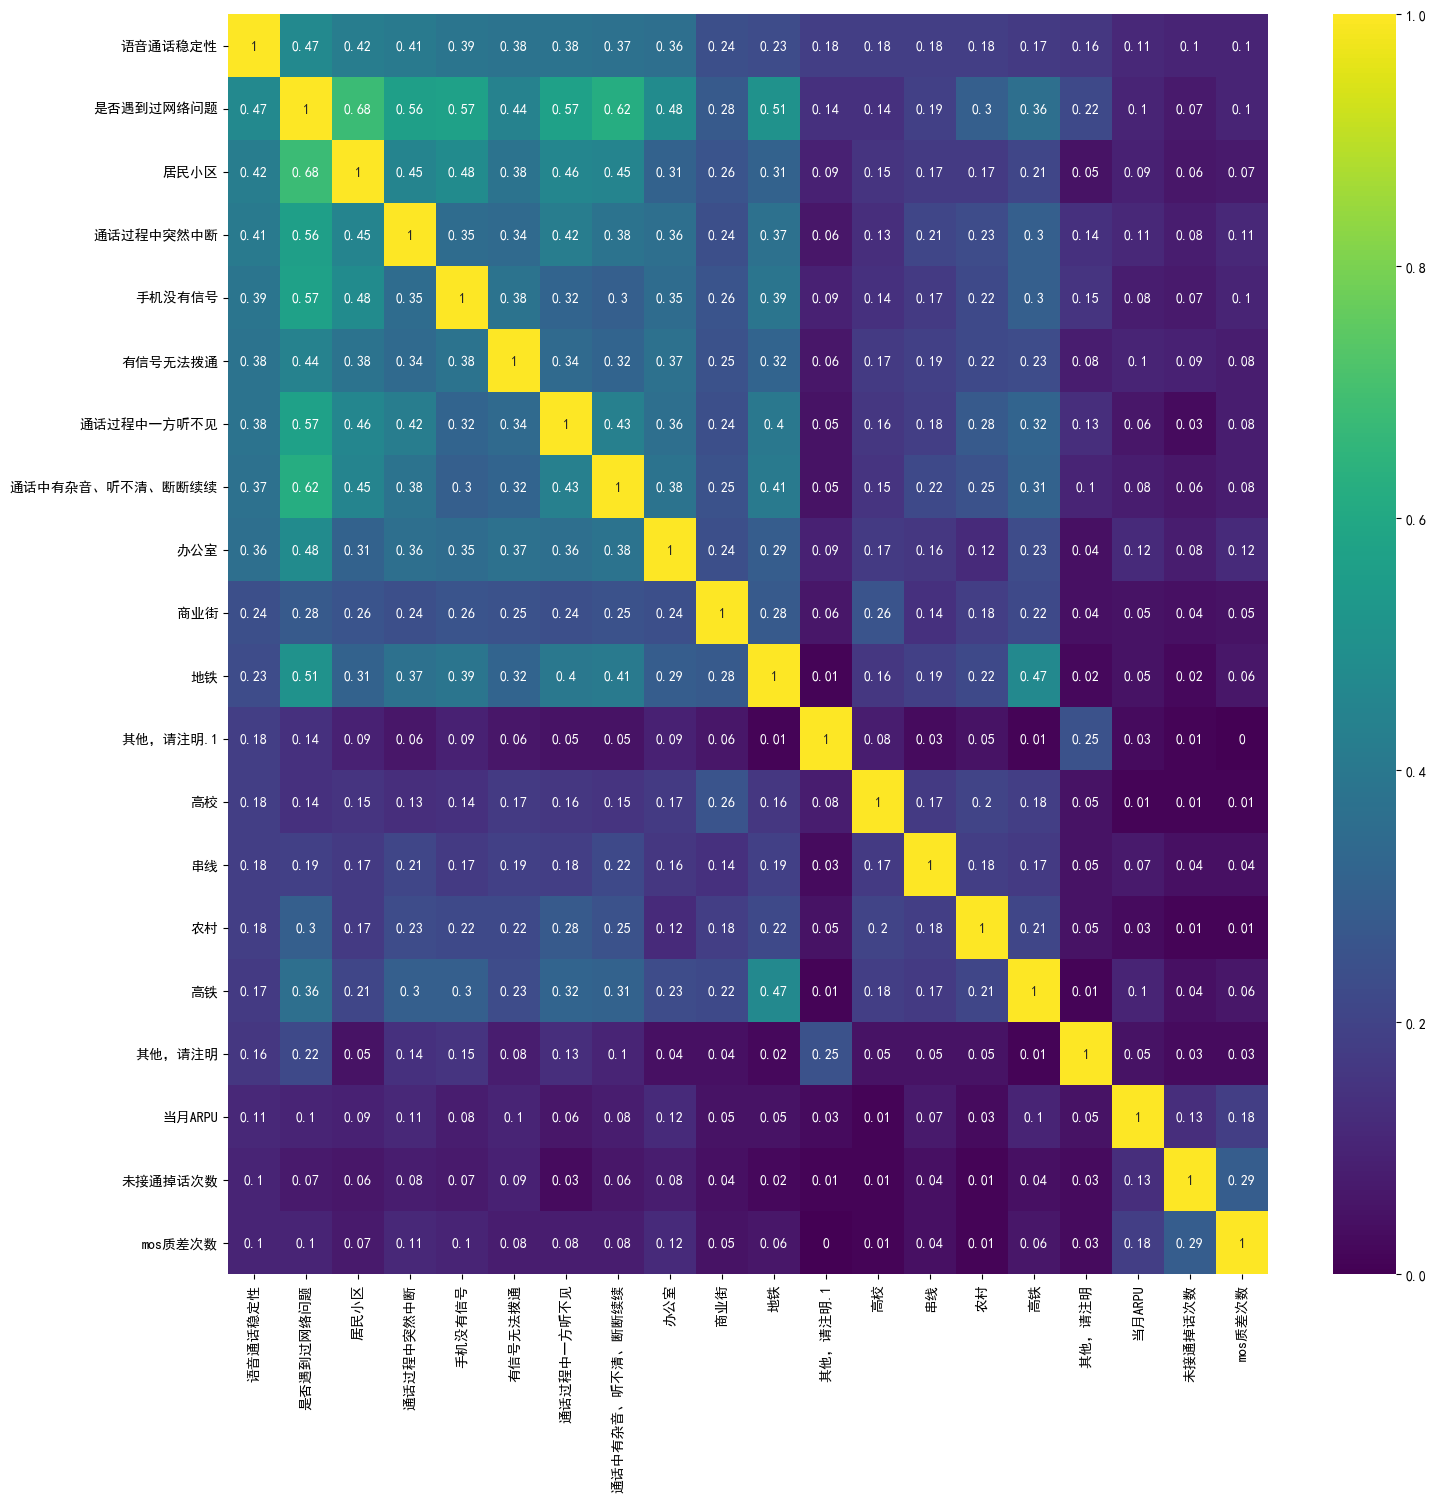

In [8]:
corr = train_data.corr().abs()
k = 20
col = corr.nlargest(k, '语音通话稳定性')['语音通话稳定性'].index   #Top10 index
corr = corr.loc[col, col]
corr = corr.round(2)

plt.subplots(figsize=(20, 20))
plt.subplots_adjust(left=0.25, bottom=0.25)
sns.heatmap(corr, annot=True, fmt="g", cmap='viridis')
plt.savefig('./output/语音通话稳定性相关性.png', dpi=300)
plt.show()

## 数据划分

In [8]:
x = train_data.loc[:, col].drop(['语音通话稳定性'],axis=1)
x

,是否遇到过网络问题,居民小区,通话过程中突然中断,手机没有信号,有信号无法拨通,通话过程中一方听不见,通话中有杂音、听不清、断断续续,办公室,商业街
0,0,0,0,0,1,0,1,1,0
1,0,1,0,0,0,1,1,1,1
2,0,0,0,1,0,1,0,0,0
3,0,1,0,1,1,0,0,1,0
4,0,0,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...
5428,0,0,1,0,0,1,0,1,0
5429,0,1,0,0,0,1,1,1,0
5430,0,0,0,1,1,0,0,0,1
5431,0,0,1,0,0,0,1,0,0


In [9]:
y = train_data["语音通话稳定性"]
y

0        6
1        1
2        7
3        6
4        3
        ..
5428     8
5429    10
5430     4
5431     9
5432    10
Name: 语音通话稳定性, Length: 5433, dtype: int64

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## 模型训练

In [11]:
rg = RidgeClassifier()
parameters = {
    "alpha":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    "normalize":[True,False]
}

rg_cv = GridSearchCV(rg, parameters, cv=5)
rg_cv.fit(x_train,y_train)
rg_cv.best_estimator_

RidgeClassifier(alpha=0.1, normalize=False)

In [12]:
dt = DecisionTreeClassifier()
parameters = {
    "criterion":['gini', 'entropy','log_loss'],
    "max_depth":[2,4,8,16,32],
    "min_samples_leaf":[2,4,8,16,32],
    "min_samples_split":[2,4,8,16,32]
}

dt_cv = GridSearchCV(dt, parameters, cv=5)
dt_cv.fit(x_train,y_train)
dt_cv.best_estimator_

DecisionTreeClassifier(max_depth=8, min_samples_leaf=32)

In [13]:
rf = RandomForestClassifier()
parameters = {
    "max_depth":[2,4,8,16,32],
    "n_estimators":[5,50,250,500]
}

rf_cv = GridSearchCV(rf, parameters, cv=5)
rf_cv.fit(x_train,y_train)
rf_cv.best_estimator_

RandomForestClassifier(max_depth=4, n_estimators=500)

In [14]:
ada = AdaBoostClassifier()
parameters = {
    "learning_rate":[0.01,0.1,1.0,10,100],
    "n_estimators":[5,50,250,500]
}

ada_cv = GridSearchCV(ada, parameters, cv=5)
ada_cv.fit(x_train,y_train)
ada_cv.best_estimator_

AdaBoostClassifier(learning_rate=0.1)

In [15]:
gb = GradientBoostingClassifier()
parameters = {
    "learning_rate":[0.01,0.1,1.0,10,100],
    "max_depth":[2,4,8,16,32],
    "n_estimators":[5,50,250,500]
}

gb_cv = GridSearchCV(gb, parameters, cv=5)
gb_cv.fit(x_train,y_train)
gb_cv.best_estimator_

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=500)

In [16]:
xgb = XGBClassifier()
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[2,4,8,16,32],
    "learning_rate":[0.01,0.1,1.0,10,100]
}

xgb_cv = GridSearchCV(xgb, parameters, cv=5)
xgb_cv.fit(x_train,y_train)
xgb_cv.best_estimator_

[12:03:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:03:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:03:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:03:52] WARNI

[12:04:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:04:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:04:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:04:10] WARNI

[12:04:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:04:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:04:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:05:03] WARNI

[12:06:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:06:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:07:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:07:23] WARNI

[12:09:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:09:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:09:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:09:28] WARNI

[12:09:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:09:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:09:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:09:46] WARNI

[12:10:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:10:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:10:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:10:38] WARNI

[12:12:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:12:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:12:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:12:49] WARNI

[12:14:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:44] WARNI

[12:15:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:01] WARNI

[12:15:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:53] WARNI

[12:17:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:17:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:17:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:17:55] WARNI

[12:19:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:42] WARNI

[12:19:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:56] WARNI

[12:20:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:11] WARNI

[12:20:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:32] WARNI

[12:20:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:47] WARNI

[12:21:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:02] WARNI

[12:21:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:22] WARNI

[12:21:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:37] WARNI

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [17]:
svr = SVC()
parameters = {
    "C":[0.001,0.01,0.1,1.0,10,100,1000],
    "kernel":["linear","poly","rbf","sigmoid"]
}

svr_cv = GridSearchCV(svr, parameters, cv=5)
svr_cv.fit(x_train,y_train)
svr_cv.best_estimator_

SVC()

In [18]:
mlp = MLPClassifier()
parameters = {
    "activation":["identity","logistic","tanh","relu"],
    "hidden_layer_sizes":[(10,),(50,),(100,)],
    "learning_rate":["constant","invscaling","adaptive"],
    "solver":["lbfgs","sgd","adam"]
}

mlp_cv = GridSearchCV(mlp, parameters, cv=5)
mlp_cv.fit(x_train, y_train)
mlp_cv.best_estimator_

MLPClassifier(activation='identity', hidden_layer_sizes=(50,),
              learning_rate='invscaling')

In [19]:
estimators = [("rg",rg_cv.best_estimator_),
              ("dt",dt_cv.best_estimator_),
              ("rf",rf_cv.best_estimator_),
              ("ada",ada_cv.best_estimator_),
              ("gb",gb_cv.best_estimator_),
              ("xgb",xgb_cv.best_estimator_),
              ("svr",svr_cv.best_estimator_),
              ("mlp",mlp_cv.best_estimator_)]

sr = StackingClassifier(estimators=estimators)
parameters = {
    "passthrough":[True,False]
}

sr_cv = GridSearchCV(sr, parameters, cv=5)
sr_cv.fit(x_train,y_train)
sr_cv.best_estimator_

[12:49:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:01] WARNI

[12:54:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:31] WARNI

[12:58:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:58:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:59:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:59:17] WARNI

StackingClassifier(estimators=[('rg',
                                RidgeClassifier(alpha=0.1, normalize=False)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=8,
                                                       min_samples_leaf=32)),
                               ('rf',
                                RandomForestClassifier(max_depth=4,
                                                       n_estimators=500)),
                               ('ada', AdaBoostClassifier(learning_rate=0.1)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.01,
                                                           max_depth=2,
                                                           n_estimators=500)),
                               ('xgb',
                                XGBClassif...
                                              monotone_constraints='()',
              

In [20]:
models = [rg_cv.best_estimator_,
          dt_cv.best_estimator_,
          rf_cv.best_estimator_,
          ada_cv.best_estimator_,
          gb_cv.best_estimator_,
          xgb_cv.best_estimator_,
          svr_cv.best_estimator_,
          mlp_cv.best_estimator_,
          sr_cv.best_estimator_]

In [43]:
val_set = pd.DataFrame()
    
for i in models:
        start = time()
        pred = i.predict(x_val)
        end = time()        
        temp = pd.DataFrame(
                {
                    "Mean Absolute Error":("%0.3f" % (mean_absolute_error(y_val,pred))),
                    "Mean Squared Error":("%0.3f" % (mean_squared_error(y_val,pred))),
                    "Root Mean Square Error":("%0.3f" % (np.sqrt(mean_squared_error(y_val,pred)))),
                    "Acc":("%0.3f" % (accuracy_score(y_val,pred))),
                    "Latency":("%0.1fms" % ((end-start)*1000))
                }, index=[(str(i).split("Regressor")[0].split("(")[0])]
        )
        val_set = pd.concat([val_set,temp])
val_set

,Mean Absolute Error,Mean Squared Error,Root Mean Square Error,Acc,Latency
RidgeClassifier,1.440,6.877,2.622,0.514,16.0ms
DecisionTreeClassifier,1.428,6.872,2.621,0.505,3.0ms
RandomForestClassifier,1.436,6.939,2.634,0.514,16.0ms
AdaBoostClassifier,1.448,6.922,2.631,0.511,28.9ms
GradientBoostingClassifier,1.443,6.990,2.644,0.514,93.7ms
XGBClassifier,1.420,6.798,2.607,0.518,9.0ms
SVC,1.436,6.891,2.625,0.507,46.9ms
MLPClassifier,1.420,6.715,2.591,0.512,5.0ms
StackingClassifier,1.452,7.062,2.657,0.506,192.5ms


## 预测（XGBClassifier）

In [27]:
test = pd.read_excel("./output/语音测试集.xlsx")

In [28]:
test_data = pd.DataFrame.copy(test, deep=True)
test_data

,用户id,是否遇到过网络问题,居民小区,办公室,高校,商业街,地铁,农村,高铁,其他，请注明,...,省际漫游-时长（分钟）,当月ARPU,当月MOU,前3月ARPU,前3月MOU,外省流量占比,GPRS总流量（KB）,GPRS-国内漫游-流量（KB）,是否5G网络客户,客户星级标识
0,1,1,0,0,0,0,0,0,0,0,...,0,45.37,161,23.6,139,0.000000,14360274,0,0,2
1,2,0,1,1,0,0,0,0,0,0,...,0,60.00,270,60.0,102,0.000000,9585266,0,0,4
2,3,1,0,0,0,0,0,0,0,0,...,0,89.00,662,89.0,80,0.000000,6545659,0,0,4
3,4,0,1,0,0,0,0,0,0,0,...,0,70.00,645,69.1,333,0.000000,8266166,0,0,4
4,5,0,1,0,0,0,0,0,0,0,...,0,56.00,496,56.0,258,0.000000,13254086,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594,2595,0,0,0,0,0,0,0,1,0,...,0,47.00,110,197.0,42,0.000000,34089161,0,0,4
2595,2596,1,0,0,0,0,0,0,0,0,...,0,57.00,238,77.0,157,0.000000,4355664,0,0,4
2596,2597,1,0,0,0,0,0,0,0,0,...,0,8.10,202,8.0,194,0.000000,27678375,0,1,4
2597,2598,0,0,0,0,0,0,1,1,0,...,0,58.20,148,58.3,66,0.061913,5410723,334996,0,4


In [33]:
test_col = col.drop('语音通话稳定性')

In [34]:
test_data = test_data.loc[:, test_col]
test_data

,是否遇到过网络问题,居民小区,通话过程中突然中断,手机没有信号,有信号无法拨通,通话过程中一方听不见,通话中有杂音、听不清、断断续续,办公室,商业街
0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,1,0
2,1,0,0,0,0,0,0,0,0
3,0,1,1,0,0,0,0,0,0
4,0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...
2594,0,0,0,1,0,0,0,0,0
2595,1,0,0,0,0,0,0,0,0
2596,1,0,0,0,0,0,0,0,0
2597,0,0,0,0,0,1,0,0,0


In [42]:
y_pred_test = xgb_cv.best_estimator_.predict(test_data)
output = pd.DataFrame({'Id': test['用户id'], '语音通话稳定性': np.round(y_pred_test, 0)})
output.to_excel('./output//result-语音通话稳定性.xlsx', index=False)